<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/Ranking/Learning_to_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to Rank

Adaptation from: [link](https://github.com/ogrisel/notebooks/blob/master/Learning%20to%20Rank.ipynb)

In this notebook, we analyse ranking technologies. We are going to review the common function to measure the success of the predicted ranker (DCG). Moreover, we present some basic ranking models. In particular, we analyse the ranking process using regressors and convert classifiers in rankers.

For more information: 
 - [Ranking with Linear models](https://opensourceconnections.com/blog/2017/04/01/learning-to-rank-linear-models/)
 - [Learning to Rank datasets and software](http://arogozhnikov.github.io/2015/06/26/learning-to-rank-software-datasets.html)
 - [Learning to Rank article](https://arxiv.org/pdf/1501.05132.pdf)

## Imports

In [1]:
%matplotlib inline
from os.path import expanduser, join
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Load dataset

To run the ranker training and testing we are going to use the [MSLR-WEB10K](http://research.microsoft.com/en-us/projects/mslr/) dataset. In particular, we use the library catboost that give us access to the dataset easily.

In [ ]:
!pip install catboost

In [4]:
from catboost.datasets import msrank_10k
train_df, test_df = msrank_10k()

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

In [5]:
# Shape of the training dataset
X_train.shape

(10000, 136)

In [6]:
# Datatype of the values in the training dataset
X_train.dtype

dtype('float64')

In [7]:
# Total size in bytes
(X_train.nbytes + X_test.nbytes) / 1e6

21.76

In [8]:
# total number of search results
len(X_train) + len(X_test)

20000

In [152]:
# total number of queries
len(np.unique(queries_train)) + len(np.unique(queries_test))

175

### Sanity check

We generate a version of the dataset balanced.

In [11]:
def balance_irrelevant(X, y, qid, seed=None):
    """Subsample the zero-scored entries"""
    rng = np.random.RandomState(seed)
    unique_qid = np.unique(qid)
    final_mask = np.ones(shape=y.shape, dtype=np.bool)
    for this_qid in unique_qid:
        this_mask = qid == this_qid
        this_y = y[this_mask]
        relevant = this_y >= 2
        ratio = float(np.mean(relevant))
        if ratio > 0.5:
            # already balanced
            continue
            
        final_mask[this_mask] = np.logical_or(
            relevant, np.random.random(len(this_y)) > 0.7) 
    return X[final_mask], y[final_mask], qid[final_mask]

X_balanced, y_balanced, qid_balanced = balance_irrelevant(X_train, y_train, queries_train)

In [12]:
print(len(X_train))
print(len(X_balanced))

10000
4085


## Quantifying ranking success with NDCG

In this section we analyse a strategy to measure the success of the ranking produced by the model. In particular, we use DCG as measure method. Furthermore, we present some ranking models (regressors).

### Calculations of Normalized DGC (NDGC)

Discounted cumulative gain (DCG) is a measure of ranking quality.

Two assumptions are made in using DCG and its related measures.

- Highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks)
- Highly relevant documents are more useful than marginally relevant documents, which are in turn more useful than non-relevant documents.

More info and equations: https://en.wikipedia.org/wiki/Discounted_cumulative_gain

In [18]:
def dcg(relevances, rank=10):
    """Discounted cumulative gain at rank (DCG)"""
    relevances = np.asarray(relevances)[:rank]
    n_relevances = len(relevances)
    if n_relevances == 0:
        return 0.

    discounts = np.log2(np.arange(n_relevances) + 2)
    return np.sum(relevances / discounts)
 
 
def ndcg(relevances, rank=10):
    """Normalized discounted cumulative gain (NDGC)"""

    # Best dcg (relevances sorted by position, high relevance at the top and lower at the bottom)
    best_dcg = dcg(sorted(relevances, reverse=True), rank)
    if best_dcg == 0:
        return 0.
    
    # Normalized DCG: DCG of predicted relevances / best dcg
    return dcg(relevances, rank) / best_dcg

Examples: We calculate the ndcg of some obtained relevances order.

In [20]:
# Similar to the best order of relevances
ndcg([2, 4, 0, 1, 1, 0, 0], rank=5)

0.8625300399291566

In [21]:
# No very similar to the best order of relevances
ndcg([0, 0, 0, 1, 1, 2, 4], rank=5)

0.13201850690866795

In [16]:
# Worst order of relevances
ndcg([0, 0, 0, 1, 1, 2, 4], rank=3)

0.0

In [17]:
# Best order of relevances
ndcg([4, 2, 1, 1, 0, 0, 0], rank=5)

1.0

### Mean NDCG

Calculate the mean value of NDCG for a list of predicted relevances

In [22]:
def mean_ndcg(y_true, y_pred, query_ids, rank=10):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    query_ids = np.asarray(query_ids)
    # assume query_ids are sorted
    ndcg_scores = []
    previous_qid = query_ids[0]
    previous_loc = 0
    for loc, qid in enumerate(query_ids):
        if previous_qid != qid:
            chunk = slice(previous_loc, loc)
            ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
            ndcg_scores.append(ndcg(ranked_relevances, rank=rank))
            previous_loc = loc
        previous_qid = qid

    chunk = slice(previous_loc, loc + 1)
    ranked_relevances = y_true[chunk][np.argsort(y_pred[chunk])[::-1]]
    ndcg_scores.append(ndcg(ranked_relevances, rank=rank))
    return np.mean(ndcg_scores)


mean_ndcg([4, 3, 1, 4, 3], [4, 0, 1, 4, 2], [0, 0, 0, 2, 2], rank=10)

0.9795191506818377

## Ranking models

### Common evaluation functions 

In [30]:
def print_evaluation(model, X, y, qid):
    tic = time()
    y_predicted = model.predict(X)
    prediction_time = time() - tic
    print("Prediction time: {:.3f}s".format(prediction_time))
    print("NDCG@5 score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=5)))
    print("NDCG@10 score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=10)))
    print("NDCG score: {:.3f}".format(
    mean_ndcg(y, y_predicted, qid, rank=None)))
    print("R2 score: {:.3f}".format(r2_score(y, y_predicted)))

In [36]:
def plot_ndcg_by_trees(model, X, y, qid, rank=10):
    max_n_trees = len(model.estimators_)
    scores = []
    
    if hasattr(model, 'staged_predict'):
        # stage-wise score computation for boosted ensembles
        n_trees = np.arange(max_n_trees) + 1
        for y_predicted in model.staged_predict(X):
            scores.append(mean_ndcg(y, y_predicted, qid, rank=10))
    else:
        # assume forest-type of tree ensemble: use a log scale to speedup
        # the computation
        # XXX: partial predictions could be reused
        n_trees = np.logspace(0, np.log10(max_n_trees), 10).astype(int)
        for j, n in enumerate(n_trees):
            y_predicted = sub_ensemble(model, n).predict(X)
            scores.append(mean_ndcg(y, y_predicted, qid, rank=rank))
            
    plt.plot(n_trees, scores)
    plt.xlabel("Number of trees")
    plt.ylabel("Average NDCG@%d" % rank)
    _ = plt.title("Impact of the number of trees")

In [40]:
def plot_importances(model):
    #plot the importances #
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(14,10))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices],
          color="b", yerr=std[indices], align="center")
    plt.xticks(range(len(indices)), indices)
    plt.xlim([-1, len(indices)])
    plt.show()

### Baseline Linear Regression model

Comparing with different optimizers and input scaling

In [ ]:
from sklearn.linear_model import LinearRegression

In [87]:
%time lr = LinearRegression().fit(X_train, y_train)

CPU times: user 149 ms, sys: 44.1 ms, total: 193 ms
Wall time: 156 ms


In [88]:
%time y_test_lr = lr.predict(X_test)

CPU times: user 3.04 ms, sys: 994 µs, total: 4.04 ms
Wall time: 6.46 ms


In [90]:
print_evaluation(lr, X_test, y_test, queries_test)

Prediction time: 0.007s
NDCG@5 score: 0.399
NDCG@10 score: 0.425
NDCG score: 0.719
R2 score: 0.046


Evaluate overfitting by comparing with training set:

In [92]:
print_evaluation(lr, X_train, y_train, queries_test)

Prediction time: 0.012s
NDCG@5 score: 0.561
NDCG@10 score: 0.561
NDCG score: 0.803
R2 score: 0.172


Let's evaluate the impact of imput feature normalization:

In [93]:
%%time

nlr = LinearRegression(normalize=True).fit(X_train, y_train)

CPU times: user 162 ms, sys: 18 ms, total: 180 ms
Wall time: 111 ms


In [94]:
print_evaluation(nlr, X_test, y_test, queries_test)

Prediction time: 0.010s
NDCG@5 score: 0.408
NDCG@10 score: 0.433
NDCG score: 0.721
R2 score: 0.036


Now, we test with the balanced dataset

In [95]:
%%time

nlr = LinearRegression(normalize=True).fit(X_balanced, y_balanced)

CPU times: user 67.7 ms, sys: 19.1 ms, total: 86.7 ms
Wall time: 62 ms


In [96]:
print_evaluation(nlr, X_test, y_test, queries_test)

Prediction time: 0.008s
NDCG@5 score: 0.405
NDCG@10 score: 0.423
NDCG score: 0.719
R2 score: -220.689


Finally, scaled dataset and SGDRegressor. This model is a linear model fitted by minimizing a regularized empirical loss with SGD (Stochastic Gradient Descent).

In [97]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
%%time

sgdlr = SGDRegressor(alpha=1e-7, learning_rate='constant', eta0=1e-5, max_iter=50).fit(X_train_scaled, y_train)

CPU times: user 177 ms, sys: 11 ms, total: 188 ms
Wall time: 192 ms


In [101]:
print_evaluation(sgdlr, X_test_scaled, y_test, queries_test)

Prediction time: 0.011s
NDCG@5 score: 0.420
NDCG@10 score: 0.438
NDCG score: 0.725
R2 score: 0.108


### Regression models 

#### Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [153]:
%%time

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: user 149 ms, sys: 14 ms, total: 163 ms
Wall time: 94.8 ms


In [154]:
print_evaluation(lr, X_test, y_test, queries_test)

Prediction time: 0.008s
NDCG@5 score: 0.399
NDCG@10 score: 0.425
NDCG score: 0.719
R2 score: 0.046


#### Extra Trees Regressor
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [24]:
%%time

from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
etr.fit(X_train, y_train)

CPU times: user 52.3 s, sys: 66.2 ms, total: 52.4 s
Wall time: 26.8 s


In [32]:
print_evaluation(etr, X_test, y_test, queries_test)

Prediction time: 0.412s
NDCG@5 score: 0.450
NDCG@10 score: 0.456
NDCG score: 0.729
R2 score: 0.093


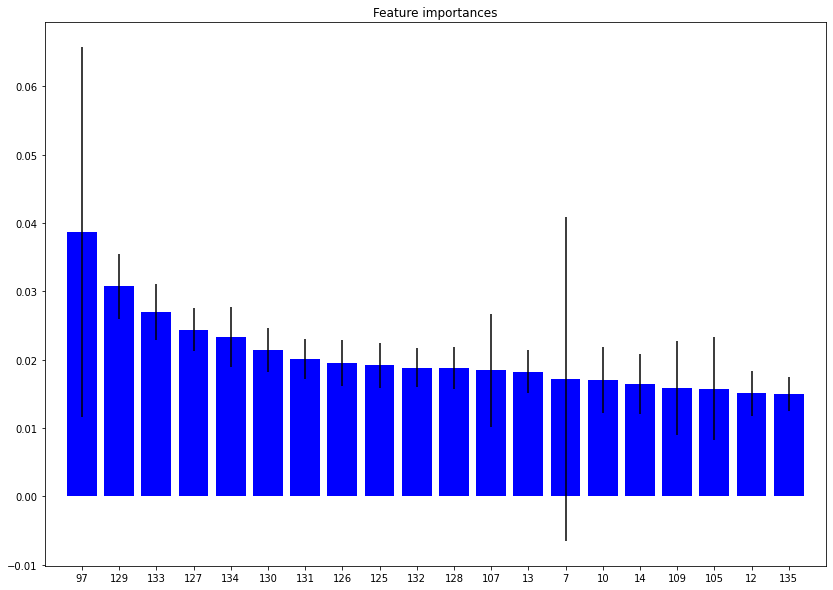

In [41]:
plot_importances(etr)

#### RandomForestRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

* Balanced dataset

In [43]:
%%time

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
rfr.fit(X_balanced, y_balanced)

CPU times: user 1min 3s, sys: 98.9 ms, total: 1min 3s
Wall time: 32.7 s


In [44]:
print_evaluation(rfr, X_test, y_test, queries_test)

Prediction time: 0.317s
NDCG@5 score: 0.456
NDCG@10 score: 0.465
NDCG score: 0.737
R2 score: -0.092


In [60]:
# plot_ndcg_by_trees(rfr, X_test, y_test, queries_test)

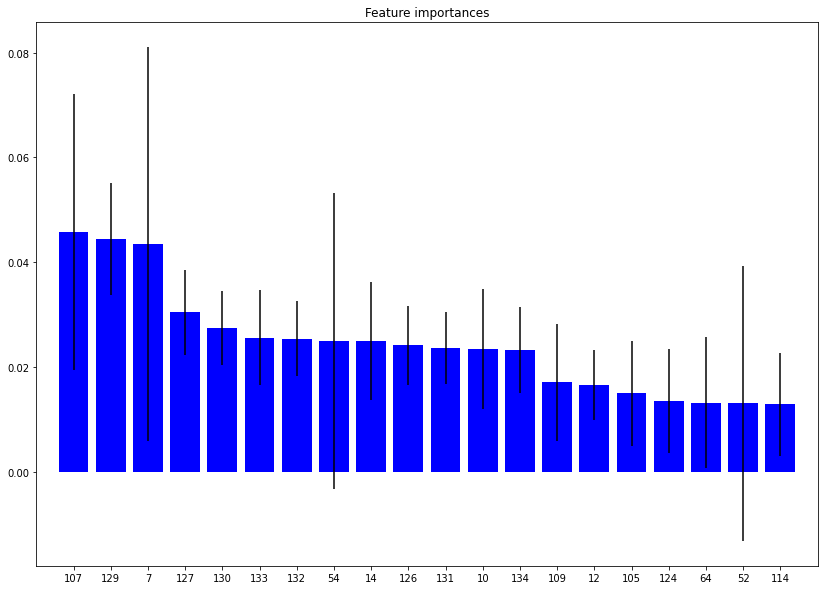

In [51]:
plot_importances(rfr)

* Raw dataset

In [47]:
%%time

from sklearn.ensemble import RandomForestRegressor

rfr2 = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
rfr2.fit(X_train, y_train)

CPU times: user 3min 8s, sys: 242 ms, total: 3min 8s
Wall time: 1min 36s


In [48]:
#rfr.set_params(n_jobs=-1)
print_evaluation(rfr2, X_test, y_test, queries_test)

Prediction time: 0.411s
NDCG@5 score: 0.494
NDCG@10 score: 0.488
NDCG score: 0.748
R2 score: 0.114


In [61]:
# plot_ndcg_by_trees(rfr2, X_test, y_test, queries_test)

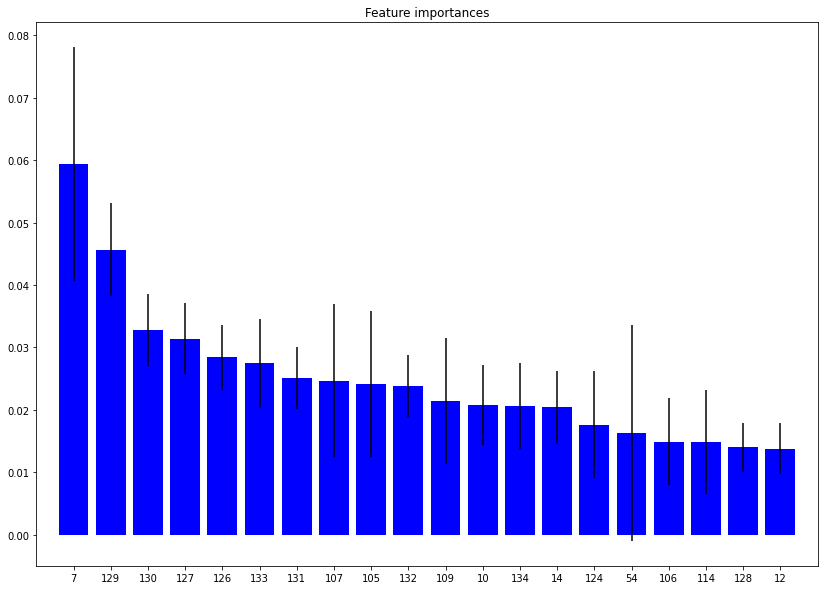

In [52]:
plot_importances(rfr2)

#### GradientBoostingRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

* Basic configuration

In [50]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200, random_state=1, verbose=1)
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.6297           39.82s
         2           0.6169           39.90s
         3           0.6055           39.94s
         4           0.5957           39.99s
         5           0.5870           39.67s
         6           0.5799           39.46s
         7           0.5732           39.07s
         8           0.5670           38.73s
         9           0.5620           39.05s
        10           0.5572           38.68s
        20           0.5242           36.02s
        30           0.5070           34.03s
        40           0.4950           31.91s
        50           0.4864           29.84s
        60           0.4781           27.88s
        70           0.4724           25.88s
        80           0.4651           23.85s
        90           0.4589           21.84s
       100           0.4523           19.83s
       200           0.4089            0.00s
CPU times: user 39.4 s, sys: 56.7 ms, total: 39.5 s
Wa

In [54]:
print_evaluation(gbr, X_test, y_test, queries_test)

Prediction time: 0.058s
NDCG@5 score: 0.468
NDCG@10 score: 0.480
NDCG score: 0.738
R2 score: 0.137


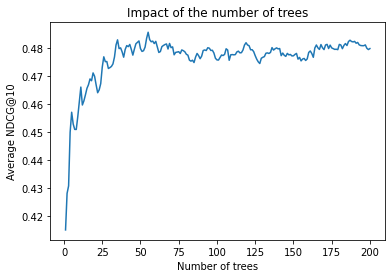

In [57]:
plot_ndcg_by_trees(gbr, X_test, y_test, queries_test)

* Extended configuration

In [62]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gbr2 = GradientBoostingRegressor(n_estimators=300, max_depth=3,
                                 learning_rate=0.1, loss='ls',
                                 random_state=1, verbose=1)
# gbr2.fit(X_dev, y_dev)
gbr2.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.6297            1.01m
         2           0.6169           59.82s
         3           0.6055           59.36s
         4           0.5957           58.71s
         5           0.5870           58.35s
         6           0.5799           58.21s
         7           0.5732           58.03s
         8           0.5670           58.22s
         9           0.5620           58.03s
        10           0.5572           57.78s
        20           0.5242           55.44s
        30           0.5070           53.38s
        40           0.4950           51.28s
        50           0.4864           49.22s
        60           0.4781           47.29s
        70           0.4724           45.27s
        80           0.4651           43.31s
        90           0.4589           41.31s
       100           0.4523           39.29s
       200           0.4089           19.54s
       300           0.3728            0.00s
CPU times

In [63]:
print_evaluation(gbr2, X_test, y_test, queries_test)

Prediction time: 0.077s
NDCG@5 score: 0.465
NDCG@10 score: 0.479
NDCG score: 0.737
R2 score: 0.125


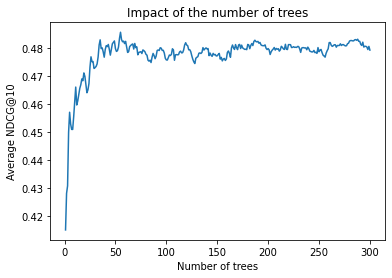

In [64]:
plot_ndcg_by_trees(gbr2, X_test, y_test, queries_test)

In [65]:
print_evaluation(gbr2, X_train, y_train, queries_test)

Prediction time: 0.063s
NDCG@5 score: 0.847
NDCG@10 score: 0.826
NDCG score: 0.913
R2 score: 0.422


In [68]:
# plot_importances(gbr2)

#### LambdaMART

Currently, `sklearn` doesn't have `LambdaMART` implementation. I use the `pyltr` implementation: https://github.com/jma127/pyltr 

In [76]:
# %%time

# from sklearn.ensemble import LambdaMART

# lmart= LambdaMART(n_estimators=300, max_depth=3,
#                   learning_rate=0.1, random_state=1, verbose=1)
# lmart.fit(X_train, y_train, group=queries_train)

In [70]:
! pip install pyltr

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import pyltr

metric = pyltr.metrics.NDCG(k=10)

# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    X_test, y_test, queries_test, metric=metric, stop_after=250)

lmart = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=1000,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=10,
    min_samples_leaf=64,
    verbose=1,
)

lmart.fit(X_train, y_train, queries_train, monitor=monitor)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.0932       0.0830        5.22m      C:      0.1059 B:      0.1059 S:  0
    2       0.2865       0.1236        5.83m      C:      0.1781 B:      0.1781 S:  0
    3       0.3241       0.0862        5.79m      C:      0.2512 B:      0.2512 S:  0
    4       0.3737       0.0239        5.88m      C:      0.2889 B:      0.2889 S:  0
    5       0.3605       0.0104        5.98m      C:      0.2887 B:      0.2889 S:  1
    6       0.3924       0.0119        5.96m      C:      0.3018 B:      0.3018 S:  0
    7       0.3647       0.0033        6.00m      C:      0.3054 B:      0.3054 S:  0
    8       0.4004       0.0207        6.00m      C:      0.3299 B:      0.3299 S:  0
    9       0.4148      -0.0028        6.07m      C:      0.3346 B:      0.3346 S:  0
   10       0.3846      -0.0114        6.05m      C:      0.3358 B:      0.3358 S:  0
   15       0.4339       0.0064        6.11m      C: 

In [84]:
Epred = lmart.predict(X_test)
print('Random ranking:', metric.calc_mean_random(queries_test, y_test))
print('Our model:', metric.calc_mean(queries_test, y_test, Epred))

Random ranking: 0.19042482876980893
Our model: 0.42415437423558716


In [78]:
print_evaluation(lmart, X_test, y_test, queries_test)

Prediction time: 0.070s
NDCG@5 score: 0.490
NDCG@10 score: 0.494
NDCG score: 0.741
R2 score: -5.262


In [80]:
# plot_ndcg_by_trees(lmart, X_test, y_test, queries_test)

### Classification models to NDCG ranking reduction models

Custom class to generate a classification ranker from different models

In [115]:
from sklearn.base import RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

def proba_to_relevance(probas):
    """MCRank-like reduction of classification proba to DCG predictions"""
    rel = np.zeros(probas.shape[0], dtype=np.float32)
    for i in range(probas.shape[1]):
        rel += i * probas[:, i]
    return rel
        
        
class ClassificationRanker(RegressorMixin):
    
    def __init__(self, base_estimator=None):
        self.base_estimator = base_estimator
        
    def fit(self, X, y):
        self.estimator_ = clone(self.base_estimator)
        self.scaler_ = StandardScaler()
        X = self.scaler_.fit_transform(X)
        self.estimator_.fit(X, y)
        
    def predict(self, X):
        X_scaled = self.scaler_.transform(X)
        probas = self.estimator_.predict_proba(X_scaled)
        return proba_to_relevance(probas)

#### LogisticRegression

In [116]:
%%time

from sklearn.linear_model import LogisticRegression

logr = ClassificationRanker(LogisticRegression(C=1000))
logr.fit(X_train, y_train)

CPU times: user 2.31 s, sys: 841 ms, total: 3.15 s
Wall time: 1.67 s


In [118]:
print_evaluation(logr, X_test, y_test, queries_test)

Prediction time: 0.025s
NDCG@5 score: 0.415
NDCG@10 score: 0.438
NDCG score: 0.727
R2 score: 0.097


#### SGDClassifier

In [119]:
%%time

from sklearn.linear_model import SGDClassifier

sgdlogr = SGDClassifier(loss='modified_huber', alpha=1e-8, max_iter=200, learning_rate='constant', eta0=1e-6, n_jobs=-1)
sgdlogrr = ClassificationRanker(sgdlogr)
sgdlogrr.fit(X_train_scaled, y_train)

CPU times: user 3.16 s, sys: 12.9 ms, total: 3.17 s
Wall time: 1.85 s


In [120]:
print_evaluation(sgdlogrr, X_test_scaled, y_test, queries_test)

Prediction time: 0.030s
NDCG@5 score: 0.410
NDCG@10 score: 0.432
NDCG score: 0.723
R2 score: -0.246


#### RandomForestClassifier

In [121]:
%%time

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, max_features=20, min_samples_split=5,
                            random_state=1, n_jobs=-1)
rfr = ClassificationRanker(rfc)
rfr.fit(X_train, y_train)

CPU times: user 28.9 s, sys: 288 ms, total: 29.2 s
Wall time: 15 s


In [122]:
print_evaluation(rfr, X_test, y_test, queries_test)

Prediction time: 0.423s
NDCG@5 score: 0.415
NDCG@10 score: 0.444
NDCG score: 0.724
R2 score: 0.116


#### GradientBoostingClassifier

In [123]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=1)
gbr = ClassificationRanker(gbc)
gbr.fit(X_train, y_train)

CPU times: user 1min 39s, sys: 109 ms, total: 1min 39s
Wall time: 1min 39s


In [124]:
print_evaluation(gbr, X_test, y_test, queries_test)

Prediction time: 0.114s
NDCG@5 score: 0.451
NDCG@10 score: 0.465
NDCG score: 0.736
R2 score: 0.105


#### ExtraTreesClassifier

In [125]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

etc = ClassificationRanker(ExtraTreesClassifier(n_estimators=200, random_state=1, n_jobs=-1))
etc.fit(X_train, y_train)

CPU times: user 7.82 s, sys: 332 ms, total: 8.15 s
Wall time: 4.32 s


In [126]:
print_evaluation(etc, X_test, y_test, queries_test)

Prediction time: 0.518s
NDCG@5 score: 0.402
NDCG@10 score: 0.415
NDCG score: 0.715
R2 score: 0.084


##Introspecting the distribution of relevance scores predictions

Ranking labels:

In [150]:
labels = set(y_test.astype(np.int))

print(f"Number of labels : {len(labels)}")
labels

Number of labels : 5


{0, 1, 2, 3, 4}

For the first 5 querys, count the number of results with rank 0, 1, 2, 3 or 4.

In [151]:
unique_qids_test = np.unique(queries_test)
for idx, qid in enumerate(unique_qids_test[:5]):
    qids = y_test[queries_test == qid].astype(np.int)
    print(f"Query : {idx} - Distribution : {np.bincount(qids, minlength=5)}")

Query : 0 - Distribution : [45 54 31  8  0]
Query : 1 - Distribution : [59 25  8  2  0]
Query : 2 - Distribution : [52 20  9  2  3]
Query : 3 - Distribution : [97 45  2  2  2]
Query : 4 - Distribution : [32 56 24  7  4]


### Plot relevances distribution

In [127]:
subset = np.random.permutation(y_test.shape[0])[:10000]

#### ExtraTreesRegressor

In [130]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=200, min_samples_split=5, random_state=1, n_jobs=-1)
etr.fit(X_train, y_train)
y_test_etr = etr.predict(X_test)

(-2.0, 5.0)

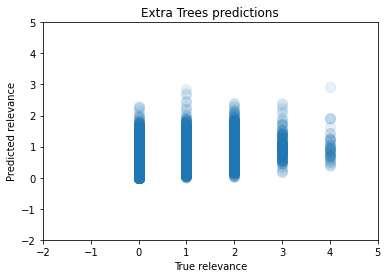

In [131]:
plt.title('Extra Trees predictions')
plt.scatter(y_test[subset], y_test_etr[subset], alpha=0.1, s=100)
plt.xlabel('True relevance')
plt.ylabel('Predicted relevance')
plt.ylim(-2, 5)
plt.xlim(-2, 5)

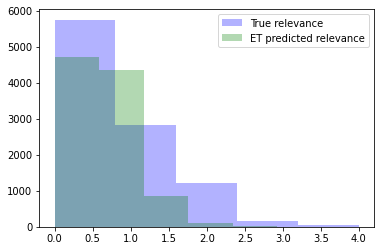

In [134]:
plt.hist(y_test, bins=5, alpha=.3, color='b', label='True relevance')
plt.hist(y_test_etr, bins=5, alpha=.3, color='g', label='ET predicted relevance')
plt.legend(loc='best')

#### LinearRegression

In [132]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
y_test_lr = lr.predict(X_test)

(-2.0, 5.0)

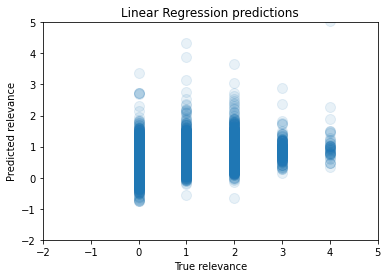

In [133]:
plt.title('Linear Regression predictions')
plt.scatter(y_test[subset], y_test_lr[subset], alpha=0.1, s=100)
plt.xlabel('True relevance')
plt.ylabel('Predicted relevance')
plt.ylim(-2, 5)
plt.xlim(-2, 5)

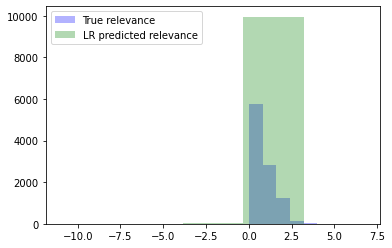

In [136]:
plt.hist(y_test, bins=5, alpha=.3, color='b', label='True relevance')
plt.hist(y_test_lr, bins=5, alpha=.3, color='g', label='LR predicted relevance')
plt.legend(loc='best')